In [263]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
from dataApi import DataApi

In [264]:
# 显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [265]:
data_api = DataApi()

In [266]:
main_exchange = "binance"
hedge_exchange = "gate"
symbol = "BNB_USDT"
start_time = "2025-10-15_00:00:00"
end_time = "2025-11-05_00:00:00"
timeframe = "1m"

In [ ]:
# 获取价格数据，价格指数，溢价指数，资金费率
main_price = data_api.price_ohlcv(main_exchange, symbol, start_time, end_time, timeframe)
hedge_price = data_api.price_ohlcv(hedge_exchange, symbol, start_time, end_time, timeframe)

main_index = data_api.index_ohlcv(main_exchange, symbol, start_time, end_time, timeframe)
hedge_index = data_api.index_ohlcv(hedge_exchange, symbol, start_time, end_time, timeframe)

main_premium = data_api.premium_index_ohlcv(main_exchange, symbol, start_time, end_time, timeframe)
hedge_premium = data_api.premium_index_ohlcv(hedge_exchange, symbol, start_time, end_time, timeframe)
# bitget的溢价指数数据缺失，需要用价格指数和现货价格计算 p - i / i
if main_exchange == "bitget":
    main_premium["timestamp"] = main_price["timestamp"]
    main_premium["close"] = (main_price["close"] - main_index["close"]) / main_index["close"]
if hedge_exchange == "bitget":
    hedge_premium["timestamp"] = hedge_price["timestamp"]
    hedge_premium["close"] = (hedge_price["close"] - hedge_index["close"]) / hedge_index["close"]

main_funding = data_api.funding_rate(main_exchange, symbol, start_time, end_time, timeframe)
hedge_funding = data_api.funding_rate(hedge_exchange, symbol, start_time, end_time, timeframe)

In [268]:
# 整理数据
main_price = main_price[["timestamp", "close"]].rename(columns={"close": "price", "timestamp": "open_time"})
hedge_price = hedge_price[["timestamp", "close"]].rename(columns={"close": "price", "timestamp": "open_time"})

main_index = main_index[["timestamp", "close"]].rename(columns={"close": "index", "timestamp": "open_time"})
hedge_index = hedge_index[["timestamp", "close"]].rename(columns={"close": "index", "timestamp": "open_time"})

main_premium = main_premium[["timestamp", "close"]].rename(columns={"close": "premium_index", "timestamp": "open_time"})
hedge_premium = hedge_premium[["timestamp", "close"]].rename(columns={"close": "premium_index", "timestamp": "open_time"})

main_funding = main_funding[["funding_time", "funding_rate"]]
hedge_funding = hedge_funding[["funding_time", "funding_rate"]]

In [269]:
# 计算funding_interval
# 先将funding_time取整到小时
HOUR_MS = 60 * 60 * 1000
main_funding["funding_time"] = main_funding["funding_time"] // HOUR_MS * HOUR_MS
hedge_funding["funding_time"] = hedge_funding["funding_time"] // HOUR_MS * HOUR_MS
main_funding["funding_time"] = pd.to_datetime(main_funding["funding_time"], unit='ms')
hedge_funding["funding_time"] = pd.to_datetime(hedge_funding["funding_time"], unit='ms')

main_funding["funding_interval"] = (main_funding["funding_time"].shift(-1) - main_funding["funding_time"]).dt.total_seconds() / 60 / 60
main_funding.dropna(inplace=True)

hedge_funding["funding_interval"] = (hedge_funding["funding_time"].shift(-1) - hedge_funding["funding_time"]).dt.total_seconds() / 60 / 60
hedge_funding.dropna(inplace=True)

# 将funding_interval取整到最近整数
main_funding["funding_interval"] = main_funding["funding_interval"].round().astype(int)
hedge_funding["funding_interval"] = hedge_funding["funding_interval"].round().astype(int)

### 绘制计算持有的funding收益
1. 计算funding_profit，使用公式：funding_profit = - binance_funding + bybit_funding
2. 计算funding_profit的累计收益
3. 绘制funding_profit的累计收益曲线

In [270]:
# 按 funding_time 合并两个交易所的资金费率数据
funding_df = main_funding.merge(
  hedge_funding, on="funding_time", how="outer", suffixes=(f"_{main_exchange}", f"_{hedge_exchange}")
).sort_values("funding_time").reset_index(drop=True)

# funding_time 已经是 datetime 类型(在前面单元格中已转换)
# 直接使用 pandas 的日期过滤
start_dt = pd.to_datetime(start_time.replace("_", " ").replace("-", "/"))
end_dt = pd.to_datetime(end_time.replace("_", " ").replace("-", "/"))

# 过滤数据
funding_df = funding_df[(funding_df["funding_time"] >= start_dt) & 
                        (funding_df["funding_time"] <= end_dt)].reset_index(drop=True)
funding_df

,funding_time,funding_rate_binance,funding_interval_binance,funding_rate_gate,funding_interval_gate
0,2025-10-15 00:00:00,-0.000204,8,-0.000024,8
1,2025-10-15 08:00:00,0.000000,8,0.000100,8
2,2025-10-15 16:00:00,0.000000,8,0.000100,8
3,2025-10-16 00:00:00,0.000000,8,0.000100,8
4,2025-10-16 08:00:00,0.000000,8,0.000100,8
...,...,...,...,...,...
59,2025-11-03 00:00:00,0.000000,8,0.000100,8
60,2025-11-03 08:00:00,0.000000,8,0.000100,8
61,2025-11-03 16:00:00,0.000000,8,0.000100,8
62,2025-11-04 00:00:00,0.000000,8,-0.000010,8


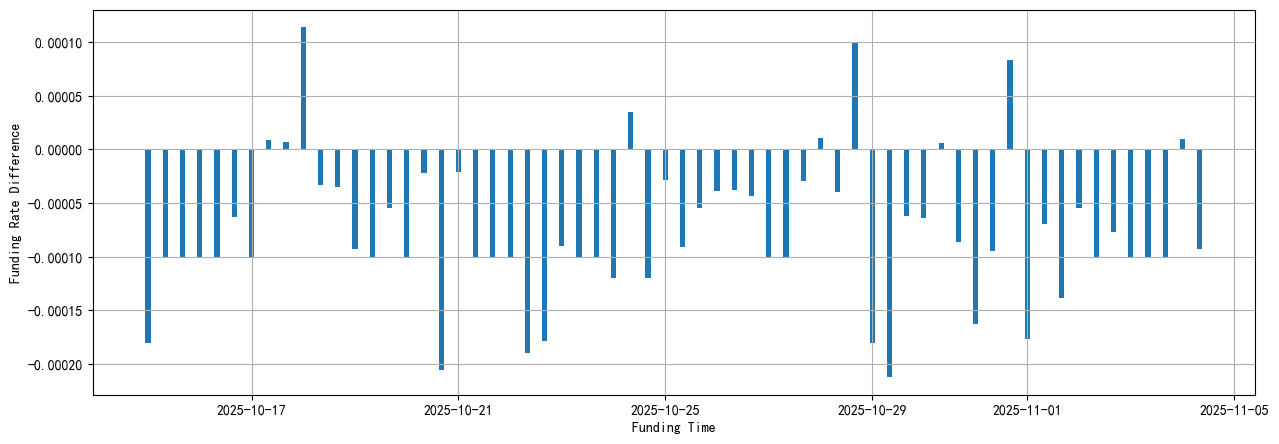

In [271]:
funding_df["diff"] = funding_df[f"funding_rate_{main_exchange}"] - funding_df[f"funding_rate_{hedge_exchange}"]
plt.figure(figsize=(15, 5))
plt.bar(funding_df["funding_time"], funding_df["diff"], width=0.1)
plt.xlabel("Funding Time")
plt.ylabel("Funding Rate Difference")
plt.grid()
plt.show()

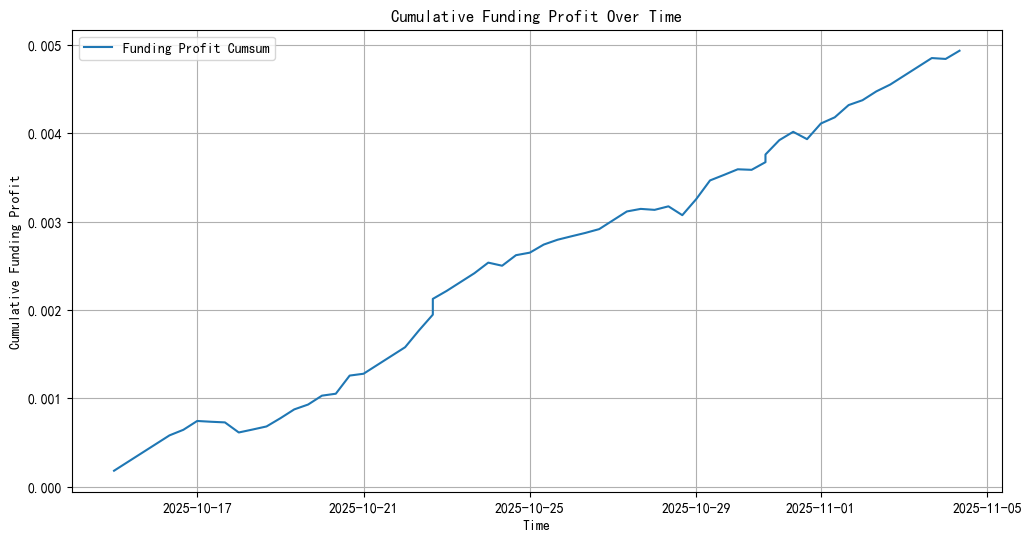

In [272]:
# 使用0填充缺失值
funding_df = funding_df.fillna(0)
# 计算 funding_profit
funding_df["funding_profit"] = -funding_df["funding_rate_{}".format(main_exchange)] + funding_df["funding_rate_{}".format(hedge_exchange)]
# 计算 funding_profit 的累计收益
funding_df["funding_profit_cumsum"] = funding_df["funding_profit"].cumsum()
# 绘制 funding_profit 的累计收益曲线
plt.figure(figsize=(12, 6))
plt.plot(funding_df["funding_time"], funding_df["funding_profit_cumsum"], label="Funding Profit Cumsum")
plt.xlabel("Time")
plt.ylabel("Cumulative Funding Profit")
plt.title("Cumulative Funding Profit Over Time")
plt.legend()
plt.grid()
plt.show()

In [273]:
# 合并文件
# 先将价格，指数，溢价指数文件按open_time合并
main_merged_df = main_price.merge(main_index, on="open_time").merge(main_premium, on="open_time")
# 先将open_time转换为datetime类型，并按时间排序
main_merged_df["open_time"] = pd.to_datetime(main_merged_df["open_time"], unit='ms')
main_merged_df = main_merged_df.sort_values("open_time")
# 合并资金费率文件
main_merged_df = main_merged_df.merge(main_funding, left_on="open_time", right_on="funding_time", how="left")
# 将funding_time与funding_rate列向上移动1行
main_merged_df["funding_time"] = main_merged_df["funding_time"].shift(-1)
main_merged_df["funding_rate"] = main_merged_df["funding_rate"].shift(-1)
# 使用下一行的funding_time与funding_rate填充当前行的NaN值，向后填充
main_merged_df["funding_time"] = main_merged_df["funding_time"].bfill()
main_merged_df["funding_rate"] = main_merged_df["funding_rate"].bfill()
# 向前填充interval
main_merged_df["funding_interval"] = main_merged_df["funding_interval"].ffill()
main_merged_df


,open_time,price,index,premium_index,funding_time,funding_rate,funding_interval
0,2025-10-15 00:00:00,1209.69,1210.327341,-5.184000e-04,2025-10-15 08:00:00,0.0,8.0
1,2025-10-15 00:01:00,1210.09,1210.501943,-3.486700e-04,2025-10-15 08:00:00,0.0,8.0
2,2025-10-15 00:02:00,1211.57,1212.104360,-4.312100e-04,2025-10-15 08:00:00,0.0,8.0
3,2025-10-15 00:03:00,1211.10,1211.522144,-5.086100e-04,2025-10-15 08:00:00,0.0,8.0
4,2025-10-15 00:04:00,1212.04,1212.759740,-5.219700e-04,2025-10-15 08:00:00,0.0,8.0
...,...,...,...,...,...,...,...
29756,2025-11-04 15:56:00,950.53,950.311280,3.446800e-04,NaT,NaN,8.0
29757,2025-11-04 15:57:00,950.54,950.342753,-5.337000e-05,NaT,NaN,8.0
29758,2025-11-04 15:58:00,951.28,951.041029,0.000000e+00,NaT,NaN,8.0
29759,2025-11-04 15:59:00,950.24,949.869779,5.000000e-08,NaT,NaN,8.0


In [274]:
# 合并文件
# 先将价格，指数，溢价指数文件按open_time合并
hedge_merged_df = hedge_price.merge(hedge_index, on="open_time").merge(hedge_premium, on="open_time")
# 先将open_time转换为datetime类型，并按时间排序
hedge_merged_df["open_time"] = pd.to_datetime(hedge_merged_df["open_time"], unit='ms')
hedge_merged_df = hedge_merged_df.sort_values("open_time")
# 合并资金费率文件
hedge_merged_df = hedge_merged_df.merge(hedge_funding, left_on="open_time", right_on="funding_time", how="left")
# 将funding_time与funding_rate列向上移动1行
hedge_merged_df["funding_time"] = hedge_merged_df["funding_time"].shift(-1)
hedge_merged_df["funding_rate"] = hedge_merged_df["funding_rate"].shift(-1)
# 使用下一行的funding_time与funding_rate填充当前行的NaN值，向后填充
hedge_merged_df["funding_time"] = hedge_merged_df["funding_time"].bfill()
hedge_merged_df["funding_rate"] = hedge_merged_df["funding_rate"].bfill()
# 向前填充interval
hedge_merged_df["funding_interval"] = hedge_merged_df["funding_interval"].ffill()
hedge_merged_df

,open_time,price,index,premium_index,funding_time,funding_rate,funding_interval
0,2025-10-15 00:00:00,1209.70,1210.0700,0.000239,2025-10-15 08:00:00,0.0001,8.0
1,2025-10-15 00:01:00,1210.05,1210.2683,-0.000182,2025-10-15 08:00:00,0.0001,8.0
2,2025-10-15 00:02:00,1211.50,1212.1633,-0.000098,2025-10-15 08:00:00,0.0001,8.0
3,2025-10-15 00:03:00,1210.95,1211.4417,-0.000465,2025-10-15 08:00:00,0.0001,8.0
4,2025-10-15 00:04:00,1212.15,1212.5600,-0.000365,2025-10-15 08:00:00,0.0001,8.0
...,...,...,...,...,...,...,...
29753,2025-11-04 15:56:00,950.05,950.0500,-0.000731,NaT,NaN,8.0
29754,2025-11-04 15:57:00,950.05,950.4200,-0.000101,NaT,NaN,8.0
29755,2025-11-04 15:58:00,950.65,951.2917,-0.000371,NaT,NaN,8.0
29756,2025-11-04 15:59:00,949.20,949.9067,-0.000507,NaT,NaN,8.0


In [275]:
# 计算资金费率的函数
def clamp(v, lower_bound=-0.0005, upper_bound=0.0005):
    return max(lower_bound, min(upper_bound, v))
def calculate_funding_rate(avg_premium_index, interval, is_new_formula, r=0.0001):
    i = interval / 8 * r
    if is_new_formula:
        funding_rate = (avg_premium_index + clamp(r-avg_premium_index)) / (8/interval)
    else:
        funding_rate = avg_premium_index + clamp(i - avg_premium_index)

    funding_rate = clamp(funding_rate, lower_bound=-0.02, upper_bound=0.02)
    return funding_rate

In [276]:
# # 计算实时funding rate
# # 先根据相同的fundingTime对数据分组再根据其其各组的序列号赋予权重
# binance_merged_df["weight"] = binance_merged_df.groupby("fundingTime").cumcount() + 1
# # 计算平均溢价指数
# binance_merged_df["premium_index_weighted"] = binance_merged_df["premium_index"] * binance_merged_df["weight"]
# binance_merged_df["avg_premium_index"] = binance_merged_df.groupby("fundingTime")["premium_index_weighted"].cumsum() / binance_merged_df.groupby("fundingTime")["weight"].cumsum()
# if symbol == "BNBUSDT":
#     binance_merged_df["real_time_funding_rate"] = binance_merged_df.apply(lambda row: calculate_funding_rate(row["avg_premium_index"], row["funding_interval"], is_new_formula=True, r=0), axis=1)
# else:
#     binance_merged_df["real_time_funding_rate"] = binance_merged_df.apply(lambda row: calculate_funding_rate(row["avg_premium_index"], row["funding_interval"], is_new_formula=True), axis=1)

# # bybit
# bybit_merged_df["weight"] = bybit_merged_df.groupby("fundingTime").cumcount() + 1
# # 计算平均溢价指数
# bybit_merged_df["premium_index_weighted"] = bybit_merged_df["premium_index"] * bybit_merged_df["weight"]
# bybit_merged_df["avg_premium_index"] = bybit_merged_df.groupby("fundingTime")["premium_index_weighted"].cumsum() / bybit_merged_df.groupby("fundingTime")["weight"].cumsum()
# bybit_merged_df["real_time_funding_rate"] = bybit_merged_df.apply(lambda row: calculate_funding_rate(row["avg_premium_index"], row["funding_interval"], is_new_formula=False), axis=1)

# 计算实时funding rate
# 先根据相同的funding_time对数据分组再根据其其各组的序列号赋予权重
main_merged_df["weight"] = main_merged_df.groupby("funding_time").cumcount() + 1
# 计算平均溢价指数
main_merged_df["premium_index_weighted"] = main_merged_df["premium_index"] * main_merged_df["weight"]
main_merged_df["avg_premium_index"] = main_merged_df.groupby("funding_time")["premium_index_weighted"].cumsum() / main_merged_df.groupby("funding_time")["weight"].cumsum()

hedge_merged_df["weight"] = hedge_merged_df.groupby("funding_time").cumcount() + 1
# 计算平均溢价指数
hedge_merged_df["premium_index_weighted"] = hedge_merged_df["premium_index"] * hedge_merged_df["weight"]
hedge_merged_df["avg_premium_index"] = hedge_merged_df.groupby("funding_time")["premium_index_weighted"].cumsum() / hedge_merged_df.groupby("funding_time")["weight"].cumsum()

# 根据交易所不同使用不同的计算方法
if main_exchange in ["binance", "bitget"]:
    r = 0. if (main_exchange == "binance" and symbol == "BNB_USDT") else 0.0001
    main_merged_df["real_time_funding_rate"] = main_merged_df.apply(lambda row: calculate_funding_rate(row["avg_premium_index"], row["funding_interval"], is_new_formula=True, r=r), axis=1)
else:
    main_merged_df["real_time_funding_rate"] = main_merged_df.apply(lambda row: calculate_funding_rate(row["avg_premium_index"], row["funding_interval"], is_new_formula=False), axis=1)

if hedge_exchange in ["binance", "bitget"]:
    r = 0. if (hedge_exchange == "binance" and symbol == "BNB_USDT") else 0.0001
    hedge_merged_df["real_time_funding_rate"] = hedge_merged_df.apply(lambda row: calculate_funding_rate(row["avg_premium_index"], row["funding_interval"], is_new_formula=True, r=r), axis=1)
else:
    hedge_merged_df["real_time_funding_rate"] = hedge_merged_df.apply(lambda row: calculate_funding_rate(row["avg_premium_index"], row["funding_interval"], is_new_formula=False), axis=1)

In [277]:
main_merged_df

,open_time,price,index,premium_index,funding_time,funding_rate,funding_interval,weight,premium_index_weighted,avg_premium_index,real_time_funding_rate
0,2025-10-15 00:00:00,1209.69,1210.327341,-5.184000e-04,2025-10-15 08:00:00,0.0,8.0,1.0,-0.000518,-0.000518,-0.000018
1,2025-10-15 00:01:00,1210.09,1210.501943,-3.486700e-04,2025-10-15 08:00:00,0.0,8.0,2.0,-0.000697,-0.000405,0.000000
2,2025-10-15 00:02:00,1211.57,1212.104360,-4.312100e-04,2025-10-15 08:00:00,0.0,8.0,3.0,-0.001294,-0.000418,0.000000
3,2025-10-15 00:03:00,1211.10,1211.522144,-5.086100e-04,2025-10-15 08:00:00,0.0,8.0,4.0,-0.002034,-0.000454,0.000000
4,2025-10-15 00:04:00,1212.04,1212.759740,-5.219700e-04,2025-10-15 08:00:00,0.0,8.0,5.0,-0.002610,-0.000477,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
29756,2025-11-04 15:56:00,950.53,950.311280,3.446800e-04,NaT,NaN,8.0,NaN,NaN,NaN,0.020000
29757,2025-11-04 15:57:00,950.54,950.342753,-5.337000e-05,NaT,NaN,8.0,NaN,NaN,NaN,0.020000
29758,2025-11-04 15:58:00,951.28,951.041029,0.000000e+00,NaT,NaN,8.0,NaN,NaN,NaN,0.020000
29759,2025-11-04 15:59:00,950.24,949.869779,5.000000e-08,NaT,NaN,8.0,NaN,NaN,NaN,0.020000


In [278]:
# 使用open_time合并两个交易所的数据
merged_df = main_merged_df.merge(hedge_merged_df, on="open_time", suffixes=(f"_{main_exchange}", f"_{hedge_exchange}"))
# 删除nan值
merged_df = merged_df.dropna()
# 重置索引
merged_df = merged_df.reset_index(drop=True)

In [279]:
merged_df

,open_time,price_binance,index_binance,premium_index_binance,funding_time_binance,funding_rate_binance,funding_interval_binance,weight_binance,premium_index_weighted_binance,avg_premium_index_binance,...,price_gate,index_gate,premium_index_gate,funding_time_gate,funding_rate_gate,funding_interval_gate,weight_gate,premium_index_weighted_gate,avg_premium_index_gate,real_time_funding_rate_gate
0,2025-10-15 00:00:00,1209.69,1210.327341,-0.000518,2025-10-15 08:00:00,0.0,8.0,1.0,-0.000518,-0.000518,...,1209.70,1210.0700,0.000239,2025-10-15 08:00:00,0.000100,8.0,1.0,0.000239,0.000239,0.0001
1,2025-10-15 00:01:00,1210.09,1210.501943,-0.000349,2025-10-15 08:00:00,0.0,8.0,2.0,-0.000697,-0.000405,...,1210.05,1210.2683,-0.000182,2025-10-15 08:00:00,0.000100,8.0,2.0,-0.000364,-0.000042,0.0001
2,2025-10-15 00:02:00,1211.57,1212.104360,-0.000431,2025-10-15 08:00:00,0.0,8.0,3.0,-0.001294,-0.000418,...,1211.50,1212.1633,-0.000098,2025-10-15 08:00:00,0.000100,8.0,3.0,-0.000293,-0.000070,0.0001
3,2025-10-15 00:03:00,1211.10,1211.522144,-0.000509,2025-10-15 08:00:00,0.0,8.0,4.0,-0.002034,-0.000454,...,1210.95,1211.4417,-0.000465,2025-10-15 08:00:00,0.000100,8.0,4.0,-0.001860,-0.000228,0.0001
4,2025-10-15 00:04:00,1212.04,1212.759740,-0.000522,2025-10-15 08:00:00,0.0,8.0,5.0,-0.002610,-0.000477,...,1212.15,1212.5600,-0.000365,2025-10-15 08:00:00,0.000100,8.0,5.0,-0.001824,-0.000273,0.0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29272,2025-11-04 07:55:00,943.38,943.054820,0.000154,2025-11-04 08:00:00,0.0,8.0,476.0,0.073423,-0.000154,...,943.00,943.0450,-0.000203,2025-11-04 08:00:00,0.000093,8.0,476.0,-0.096626,-0.000391,0.0001
29273,2025-11-04 07:56:00,944.39,943.925030,0.000362,2025-11-04 08:00:00,0.0,8.0,477.0,0.172526,-0.000151,...,943.90,944.0017,0.000000,2025-11-04 08:00:00,0.000093,8.0,477.0,0.000000,-0.000389,0.0001
29274,2025-11-04 07:57:00,943.66,943.281774,0.000214,2025-11-04 08:00:00,0.0,8.0,478.0,0.102311,-0.000150,...,943.25,943.2367,0.000000,2025-11-04 08:00:00,0.000093,8.0,478.0,0.000000,-0.000387,0.0001
29275,2025-11-04 07:58:00,944.21,943.928455,0.000234,2025-11-04 08:00:00,0.0,8.0,479.0,0.112158,-0.000148,...,943.60,944.0417,0.000000,2025-11-04 08:00:00,0.000093,8.0,479.0,0.000000,-0.000386,0.0001


In [280]:
# merged_df = merged_df[-2*24*60:-24*60]  # 取最近24小时数据
# merged_df = merged_df[-32*60:]  # 取最近24小时数据
# merged_df = merged_df[:24*60]  # 取前24小时数据

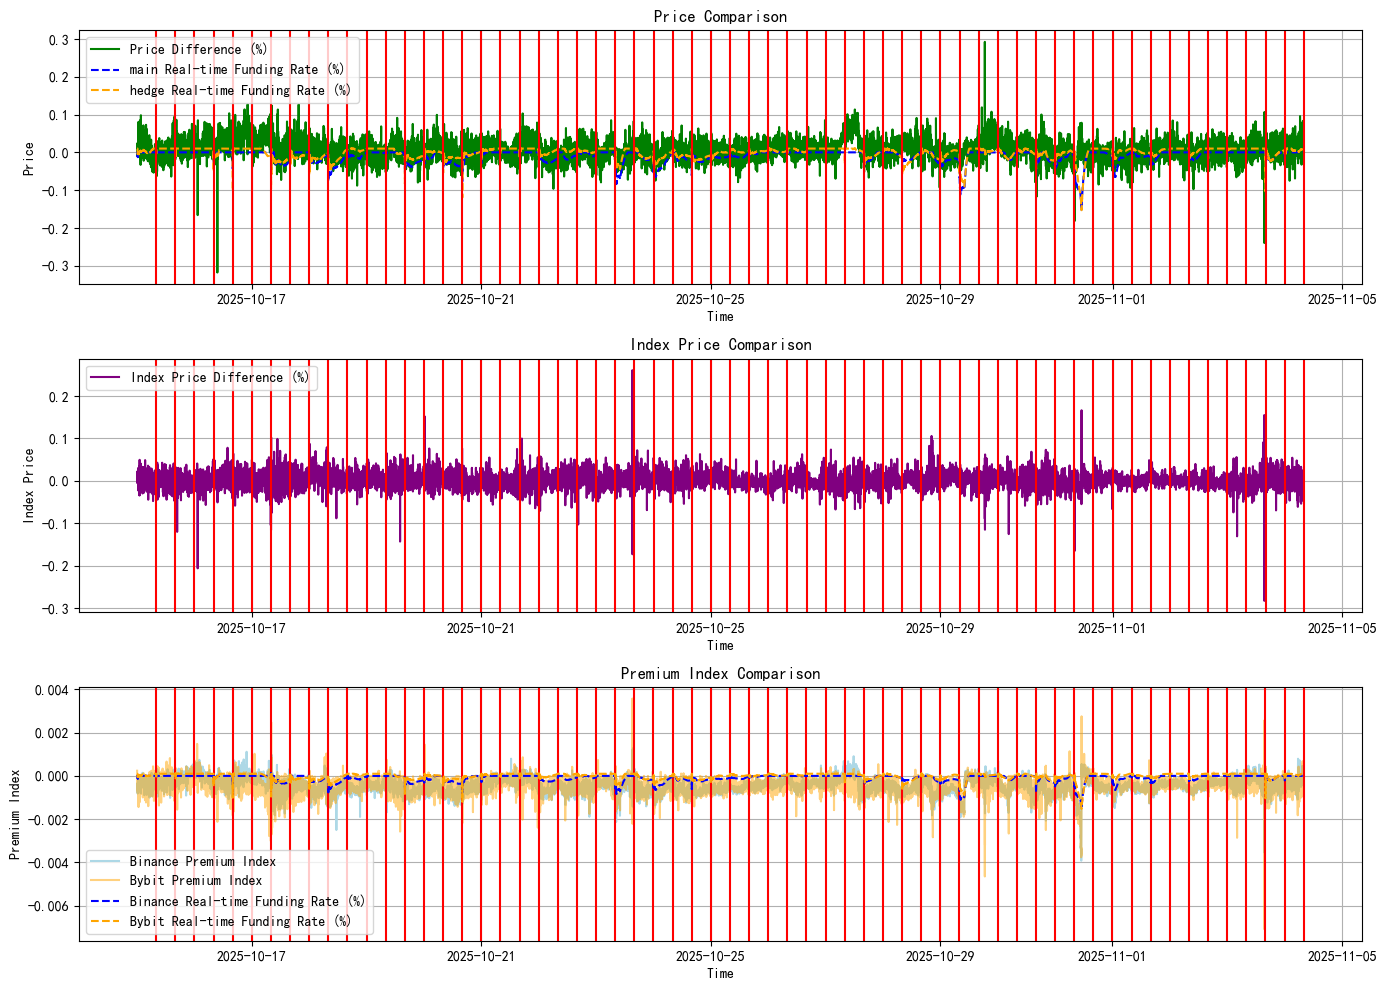

In [281]:
# merged_df = merged_df[-8*60:]  # 取前24小时数据
# 使用三张图片展示价格，指数，溢价指数的对比
plt.figure(figsize=(14, 10))
plt.subplot(3, 1, 1)
# plt.plot(merged_df["open_time"], merged_df["price_binance"], label="Binance Price", color="blue")
# plt.plot(merged_df["open_time"], merged_df["price_bybit"], label="Bybit Price", color="orange")
# 绘制百分比
plt.plot(merged_df["open_time"], (merged_df[f"price_{main_exchange}"] - merged_df[f"price_{hedge_exchange}"]) / merged_df[f"price_{hedge_exchange}"] * 100, label="Price Difference (%)", color="green")
# 添加绘制实时funding rate
plt.plot(merged_df["open_time"], merged_df[f"real_time_funding_rate_{main_exchange}"] * 100, label="main Real-time Funding Rate (%)", color="blue", linestyle='--')
plt.plot(merged_df["open_time"], merged_df[f"real_time_funding_rate_{hedge_exchange}"] * 100 * 1, label="hedge Real-time Funding Rate (%)", color="orange", linestyle='--')
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Price Comparison")
plt.legend()
plt.grid()
plt.subplot(3, 1, 2)
# plt.plot(merged_df["open_time"], merged_df["index_price_binance"], label="Binance Index Price", color="blue")
# plt.plot(merged_df["open_time"], merged_df["index_price_bybit"], label="Bybit Index Price", color="orange")
# 绘制百分比
plt.plot(merged_df["open_time"], (merged_df[f"index_{main_exchange}"] - merged_df[f"index_{hedge_exchange}"]) / merged_df[f"index_{hedge_exchange}"] * 100, label="Index Price Difference (%)", color="purple")
plt.xlabel("Time")
plt.ylabel("Index Price")
plt.title("Index Price Comparison")
plt.legend()
plt.grid()
plt.subplot(3, 1, 3)
plt.plot(merged_df["open_time"], merged_df[f"premium_index_{main_exchange}"], label="Binance Premium Index", color="lightblue")
plt.plot(merged_df["open_time"], merged_df[f"premium_index_{hedge_exchange}"], label="Bybit Premium Index", color="orange", alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Premium Index")
plt.title("Premium Index Comparison")
plt.legend()
plt.grid()

# 在每一张图上绘制fundingTime
# 其中如果只有只有一个交易所有进行结算时，使用红色虚线
# 如果两个交易所都有进行结算时，使用红色实线
binance_funding_times = merged_df[f"funding_time_{main_exchange}"].dropna().unique()
bybit_funding_times = merged_df[f"funding_time_{hedge_exchange}"].dropna().unique()
all_funding_times = sorted(set(binance_funding_times) | set(bybit_funding_times))
for ft in all_funding_times:
    if ft in binance_funding_times and ft in bybit_funding_times:
        plt.subplot(3, 1, 1)
        plt.axvline(x=ft, color='red', linestyle='-')
        plt.subplot(3, 1, 2)
        plt.axvline(x=ft, color='red', linestyle='-')
        plt.subplot(3, 1, 3)
        plt.axvline(x=ft, color='red', linestyle='-')
    else:
        plt.subplot(3, 1, 1)
        plt.axvline(x=ft, color='red', linestyle='--')
        plt.subplot(3, 1, 2)
        plt.axvline(x=ft, color='red', linestyle='--')
        plt.subplot(3, 1, 3)
        plt.axvline(x=ft, color='red', linestyle='--')

# 在最后一张图上绘制资金费率
plt.subplot(3, 1, 3)
# # 使用双y轴
# ax2 = plt.gca().twinx()
# ax2.plot(merged_df["open_time"], merged_df["fundingRate_binance"] * 100, label="Binance Funding Rate (%)", color="green", linestyle='--')
# ax2.plot(merged_df["open_time"], merged_df["fundingRate_bybit"] * 100, label="Bybit Funding Rate (%)", color="purple", linestyle='--')
# ax2.set_ylabel("Funding Rate (%)")
# ax2.legend(loc='upper right')
# 使用单y轴
# plt.plot(merged_df["open_time"], merged_df["fundingRate_binance"], label="Binance Funding Rate (%)", color="green", linestyle='--')
# plt.plot(merged_df["open_time"], merged_df["fundingRate_bybit"]*1, label="Bybit Funding Rate (%)", color="purple", linestyle='--')
# plt.legend(loc='lower right')
# 添加绘制实时funding rate
plt.plot(merged_df["open_time"], merged_df[f"real_time_funding_rate_{main_exchange}"], label="Binance Real-time Funding Rate (%)", color="blue", linestyle='--')
plt.plot(merged_df["open_time"], merged_df[f"real_time_funding_rate_{hedge_exchange}"] * 1, label="Bybit Real-time Funding Rate (%)", color="orange", linestyle='--')
plt.legend()

# 绘制30分钟的bybit溢价指数的均线
# merged_df["premium_index_bybit_ma30"] = merged_df["premium_index_bybit"].ewm(span=30).mean()
# plt.plot(merged_df["open_time"], (merged_df["premium_index_bybit_ma30"]*8).apply(lambda x: clamp(x,-0.16,0.16)), label="Bybit Premium Index MA30", color="red", linestyle='--')
# plt.legend()

plt.tight_layout()
plt.show()

In [282]:
# merged_df = merged_df[:24*60]  # 取前24小时数据
# merged_df = merged_df[24*60:]  # 取后24小时数据

In [283]:
# 分析point funding
is_new_formula = False
r = 0.0001
if main_exchange in ["binance", "bitget"]:
    is_new_formula = True
    r = 0. if (main_exchange == "binance" and symbol == "BNB_USDT") else 0.0001

merged_df[f"point_funding_{main_exchange}"] = merged_df.apply(lambda row: calculate_funding_rate(row[f"premium_index_{main_exchange}"], row[f"funding_interval_{main_exchange}"], is_new_formula, r), axis=1)

is_new_formula = False
r = 0.0001
if hedge_exchange in ["binance", "bitget"]:
    is_new_formula = True
    r = 0. if (hedge_exchange == "binance" and symbol == "BNB_USDT") else 0.0001
merged_df[f"point_funding_{hedge_exchange}"] = merged_df.apply(lambda row: calculate_funding_rate(row[f"premium_index_{hedge_exchange}"], row[f"funding_interval_{hedge_exchange}"], is_new_formula, r), axis=1)


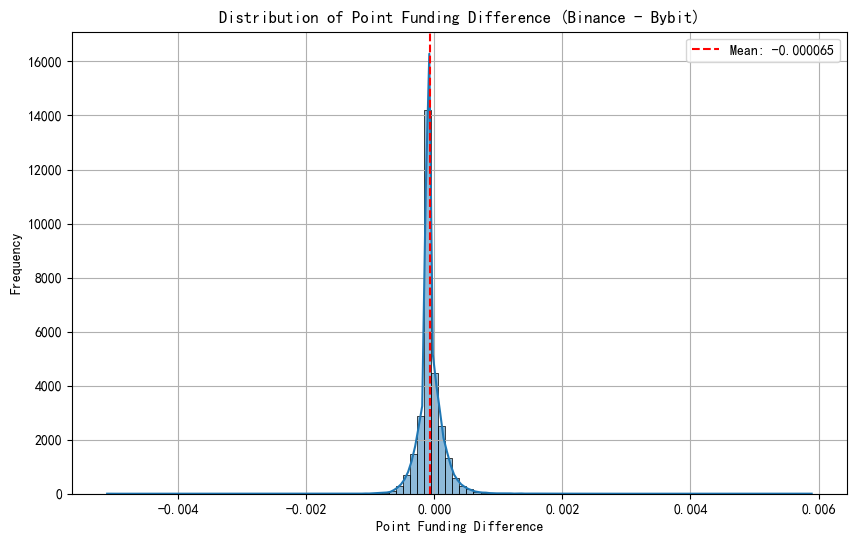

In [284]:
merged_df["point_funding_diff"] = merged_df[f"point_funding_{main_exchange}"] - merged_df[f"point_funding_{hedge_exchange}"]
# 绘制point funding diff的分布图
plt.figure(figsize=(10, 6))
sns.histplot(merged_df["point_funding_diff"], bins=100, kde=True)
# 添加绘制均值
mean_point_funding_diff = merged_df["point_funding_diff"].mean()
plt.axvline(x=mean_point_funding_diff, color='red', linestyle='--', label=f'Mean: {mean_point_funding_diff:.6f}')
plt.title("Distribution of Point Funding Difference (Binance - Bybit)")
plt.xlabel("Point Funding Difference")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()

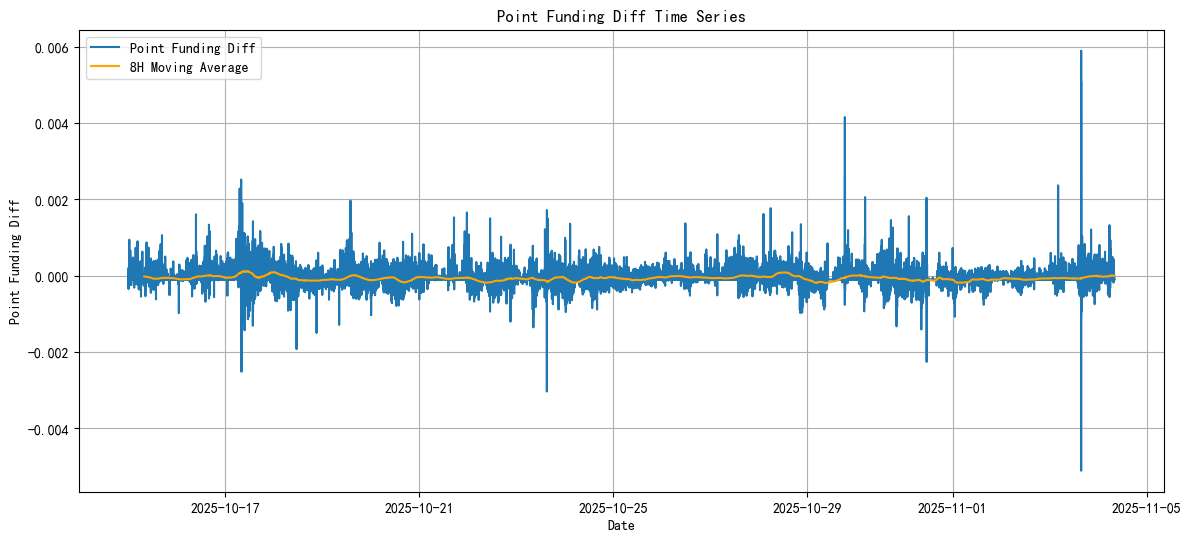

In [285]:
# 绘制point funding diff的时间序列图
plt.figure(figsize=(14, 6))
plt.plot(merged_df["open_time"], merged_df["point_funding_diff"], label='Point Funding Diff')
# 绘制8h移动平均线
merged_df["point_funding_diff_8h_ma"] = merged_df["point_funding_diff"].rolling(window=8*60).mean()
plt.plot(merged_df["open_time"], merged_df["point_funding_diff_8h_ma"], label='8H Moving Average', color='orange')
plt.title('Point Funding Diff Time Series')
plt.xlabel('Date')
plt.ylabel('Point Funding Diff')
plt.legend()
plt.grid()
plt.show()